# Popy

## Hintergrund
- Jedes ABM beinhaltet eine gewisse Form von Interaktionsraum (Netzwerk).
- Interaktionsräume in ABMs basieren meist entweder auf generischen Mustern (Grid) und einfachen Netzwerkmodellen, in denen die Agenten zufällige Positionen einnehmen
- Eine Implementierung von Interaktionsräumen, in denen Agenten nicht zufällig, sondern aufgrund von bestimmten individuellen Attributen miteinander interagieren, ist in der Regel schwierig umzusetzen
- Die gezielte Implementierung von Interaktionen/Ties zwischen bestimmten Agenten mit bestimmten individuellen Attributen kann jedoch wichtig sein, wenn man z.B. realistischere Interaktionsräume nachbilden möchte

## Ziele
- Popy ermöglicht die einfache & flexible Implementierung von Interaktionsräumen in ABM, in denen sich Agenten aufgrund bestimmter Attribute begegnen, mithilfe einer einheitlichen Syntax
- Popy vereinfacht die Erstellung von Agenten auf Basis von Survey-Daten und somit die empirische Fundierung der Agenten-Attribute
- großes und übergeordnetes Ziel: realistischere und empirischere Populationen in ABMs

Todos:

- Erstellung der Locations überarbeiten (Locations nach und nach voll machen)
- Bei Erstellung der Locations verschiedene Möglichkeiten anbieten
- Verschmelzen von Locations ermöglichen
- Analyse-Tools schick machen
- Location.group() in Location.split() umbenennen?
- Es schaffen, dass Standardnetzwerklayouts mithilfe von Locations erstellt werden können (Ring, Grid, Small World etc.)

## Statische Netzwerke

### Agenten erstellen

In Popy werden Agenten und ihre Attribute typischerweise auf Basis eines `pandas.DataFrame` erstellt.
Im Folgenden erstellen wir daher per Hand einen kleinen DataFrame, welchen wir zu Beginn für die Erstellung der Agenten nutzen.

In [1]:
import pandas

data = {
    "age": [22, 24, 60, 55, 70, 70, 35, 34, 40, 45, 50, 40, 32, 33],
    "gender": ["m", "w", "m", "w", "m", "w", "m", "w", "m", "w", "m", "w", "m", "w"],
    "favorite_food": ["cheese", "cheese", "pizza", "pizza", "pizza", "pizza", "pizza", "pizza", "cheese", "cheese", "cheese", "cheese", "pizza", "pizza"],
    "time_at_restaurant": [1, 1, 2, 2, 1, 1, 2, 2, 3, 3, 5, 5, 2, 2],
    "couple_id": [1, 1, 2, 2, 3, 7, 4, 4, 5, 5, 6, 6, 7, 3],
}

df = pandas.DataFrame(data)

df

,age,gender,favorite_food,time_at_restaurant,couple_id
0,22,m,cheese,1,1
1,24,w,cheese,1,1
2,60,m,pizza,2,2
3,55,w,pizza,2,2
4,70,m,pizza,1,3
5,70,w,pizza,1,7
6,35,m,pizza,2,4
7,34,w,pizza,2,4
8,40,m,cheese,3,5
9,45,w,cheese,3,5


Wir starten nun mit der Definition unserer Agenten als Klasse.
Wir definieren unsere Klasse `Agent` als Kind-Klasse der durch Popy bereit gestellten Klasse `popy.Agent`.
Zudem fügen wir dem Agenten für dieses Beispiel das Instanz-Attribut `self.happiness` mit dem Wert `10` hinzu, welches aber zunächst nicht weiter verwendet wird.

In [2]:
import popy

class Agent(popy.Agent):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)
        self.happiness = 10

Nun beginnen wir mit der Erstellung unserer ersten Population.
Für diese Aufgabe stellt **Popy** den sogenannten `PopMaker` zur Verfügung.
Unten wird dieser importiert und eine Instanz erstellt.
Wie du siehst, erwartet der `PopMaker` ebenfalls ein `Model`-Objekt als Argument.

In [3]:
from popy.pop_maker import PopMaker

pop_maker = PopMaker()

agents = pop_maker.create_agents(agent_class=Agent, df=df)

agents

AgentList (14 objects)

Wir sehen, dass `pop_maker` eine sogenannte `AgentList` erstellt hat.
Dies ist eine spezielle Form der Liste, welche die erstellten Agenten enthält.

Schauen wir uns mal beispielhaft den ersten Agenten der Liste an:

In [4]:
type(agents[0])

__main__.Agent

In [5]:
vars(agents[0])

{'_var_ignore': [],
 'id': 1,
 'type': 'Agent',
 'log': {},
 'model': Model,
 'p': {},
 'happiness': 10,
 'age': 22,
 'gender': 'm',
 'favorite_food': 'cheese',
 'time_at_restaurant': 1,
 'couple_id': 1}

Wir sehen, dass der Agent neben einer Reihe weiterer Attribute das Attribute `happiness` sowie die Attribute, welche im DataFrame definiert wurden, enthält.

### Erste Location erstellen

Bisher stehen die Agenten noch unverbunden nebeneinander, da noch kein Interaktionsraum definiert wurde.
Popy ermöglicht es nun, Verbindungen zwischen spezifischen Agenten auf Basis ihrer jeweiligen Attribute zu erstellen.
Dazu muss man in Popy sogenannte *Locations* definieren.
Dies sind bestimmte Objekt-Typen, die über die Spezifikation bestimmter Attribute und Methoden, Verbindungen zwischen bestimmten Agenten herstellen.
Während der Definition der Locations dienen diese sozusagen als Interface bzw. als Syntax zur Spezifikation des Interaktionsraumes.
Auf Ebene der Simulation kannst du dir die Locations wirklich als *Orte* vorstellen, an denen sich Agenten treffen und miteinander interagieren können.

Unten definieren wir unseren ersten Ort: ein Restaurant.
Bei der Definition der Ort-Klasse muss diese von der durch Popy bereit gestellten Ort-Basis-Klasse erben.

In [6]:
class Restaurant(popy.Location):
    pass

Für unser Restaurant bestimmen wir erstmal keine weiteren Eigenschaften und übernehmen dadurch alle Grundkonfigurationen der Elternklasse `popy.Location`.
Nachdem der Ort definiert wurde, können wir diesen erstellen.
Hierfür bietet der `PopMaker` die Methode `create_locations()`.
Diese Methode erstellt die unter dem Parameter `location_classes` angegebenen Locations in Abhängigkeit zu der unter dem Parameter `agents` angegebenen Population von Agenten.
Was der letzte Punkt genau heißt, werden wir später sehen.
Wichtig ist hier noch zu erwähnen, dass die Locations nicht nur erstellt werden, sondern die Agenten auch den entsprechenden Locations zugewiesen werden.

In [7]:
locations = pop_maker.create_locations(agents=agents, location_classes=[Restaurant])

Wie wir unten in der `LocationList` namens `locations` sehen können, haben wir eine Location des Typs `Restaurant` erstellt.

In [8]:
locations

LocationList (1 object)

In [9]:
locations[0]

Restaurant (Obj 16)

Da wir keine genaueren Spezifikationen des Restaurants vorgenommen haben, wurden dieser alle Agenten zugewiesen.
Das heißt, dass alle 10 Agenten dieses eine Restaurant besuchen.
Das lässt sich nachvollziehen, indem wir uns das Attribut `Location.agents` des Restaurants anschauen:

In [10]:
locations[0].agents

AgentList (14 objects)

Im Hintergrund hat sich jedoch auch etwas in Bezug auf die Agenten verändert.
Alle Agenten, die denselben Ort besuchen, stehen in Verbindung zueinander - in Worten der Netzwerkanalyse besteht also ein Edge zwischen diesen.
Dies können wir auf der Agenten-Ebene nachvollziehen, indem wir die Methode `Agent.neighbors()` ausführen.
Unten rufen wir diese Methode für den ersten Agenten auf.
Wir bekommen eine `AgentList` mit 9 Objekten zurück.
Dies bedeutet, dass der entsprechende Agent mit den 9 anderen Agenten in Verbindung steht.
Dies macht Sinn, denn alle 10 Agenten wurden dem einen existierenden Restaurant zugeordnet.

In [11]:
agents[0].neighbors()

AgentList (13 objects)

Eine Möglichkeit, einen Überblick über die erstellten Orte und die entstandenen Verknüpfungen zu bekommen, ist die Methode `PopMaker.eval_affiliations()`.
Diese zeigt, wie viele Agenten (durchschnittlich) pro Location-Typ zugordnet wurden und wie viele Locations (durchschnittlich) einem Agenten zugeordnet wurden.

In [12]:
pop_maker.eval_affiliations()



______________________________________
Number of agents per location
______________________________________

               n_agents                                        
                  count  mean std   min   25%   50%   75%   max
location_class                                                 
Restaurant          1.0  14.0 NaN  14.0  14.0  14.0  14.0  14.0


______________________________________
Number of affiliated locations per agent
______________________________________

count    14.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: n_affiliated_locations, dtype: float64


In [13]:
vars(agents[2])

{'_var_ignore': [],
 'id': 3,
 'type': 'Agent',
 'log': {},
 'model': Model,
 'p': {},
 'happiness': 10,
 'age': 60,
 'gender': 'm',
 'favorite_food': 'pizza',
 'time_at_restaurant': 2,
 'couple_id': 2}

Einen noch plastischeren Eindruck über die entstandenen Verbindungen gewinnt man, wenn man sich die Verknüpfungen der Agenten als Netzwerk anschaut:

In [14]:
from bokehgraph import BokehGraph
import popy.utils as utils

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

Da alle Agenten ein einziges Restaurant besuchen, treffen alle Agenten aufeinander und ein vollverbundenes Netzwerk entsteht.

Eine weitere Möglichkeit das Netzwerk zu evaluieren ist das Erstellen einer Kontaktmatrix:

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
14,1,1,1,1,1,1,1,1,1,1,1,1,1,0
13,1,1,1,1,1,1,1,1,1,1,1,1,0,1
12,1,1,1,1,1,1,1,1,1,1,1,0,1,1
11,1,1,1,1,1,1,1,1,1,1,0,1,1,1
10,1,1,1,1,1,1,1,1,1,0,1,1,1,1
9,1,1,1,1,1,1,1,1,0,1,1,1,1,1
8,1,1,1,1,1,1,1,0,1,1,1,1,1,1
7,1,1,1,1,1,1,0,1,1,1,1,1,1,1
6,1,1,1,1,1,0,1,1,1,1,1,1,1,1
5,1,1,1,1,0,1,1,1,1,1,1,1,1,1


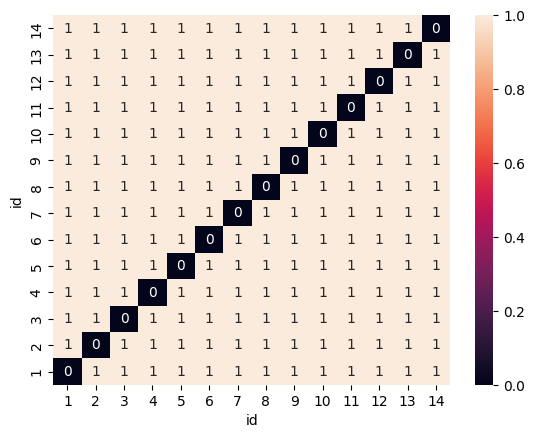

In [15]:
utils.create_contact_matrix(agents=agents, plot=True)

Diese kann nicht nur auf der Ebene der einzelnen Agenten erstellt werden, sondern auch auf der Ebene bestimmter Gruppenmerkmale:

,cheese,pizza
pizza,48,56
cheese,30,48


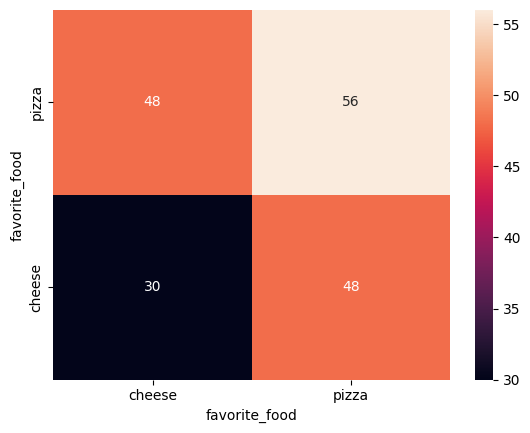

In [16]:
utils.create_contact_matrix(agents=agents, plot=True, attr="favorite_food")

### Agents & Locations in einem Rutsch erstellen

Wir kennen nun die beiden Methoden `PopMaker.create_agents()` und `PopMaker.create_locations()`.
Da wir in Popy sowieso typischerweise sowohl Agents als auch Locations brauchen, gibt es praktische Methode, die beides auf einmal erstellt: `PopMaker.make()`:

In [17]:
agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Restaurant])

Diese Methode hat übrigens noch ein paar weitere praktische Funktionen, die wir etwas später kennenlernen werden.

### Location-Zugang einschränken

Nun wollen wir die Eigenschaften des Restaurants etwas ausweiten.
Mithilfe der Methode `Location.join()` bestimmen wir, dass nur Agenten, deren Alter größer als 30 ist, das Restaurant besuchen.

In [18]:
class Restaurant(popy.Location):
    def join(self, agent):
        return agent.age > 30

In [19]:
agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Restaurant])

Nun sieht das entstehende Netzwerk so aus, da zwei Agenten nicht älter als 30 sind:

In [20]:
graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

### Sub-Locations erzeugen

Die Methode `Location.group()` ermöglicht es unkompliziert Sub-Locations einer Location zu erstellen.
Für jeden Wert, der pro Agent durch `Location.group()` zurück gegeben wird, wird eine Sub-Location erstellt.
Im Beispiel unten wird nun für jedes Lieblingsessen der Agenten ein eigenes Restaurant geschaffen.

In [21]:
class Restaurant(popy.Location):       
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.favorite_food

In [22]:
agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Restaurant])

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

### Location-Größe einstellen

Innerhalb der Methode `Location.setup()` können verschiedene Eigenschaften einer Location bestimmt werden, wie z.B. die Größe `self.size` d.h. die Anzahl der nodes pro Location.
Der `PopMaker` liest diese Werte aus und erstellt dann die benötigte Anzahl der entsprechenden Location.

In [23]:
class Restaurant(popy.Location):
    def setup(self):
        self.size = 4
        
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.favorite_food

In [24]:
agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Restaurant])

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

### Agenten zusammen halten

Wenn du dir die Zusammensetzung der Nodes genauer anschaust, fällt dir vielleicht etwas auf: Nicht alle Paare sind jeweils im selben Restaurant.
Wir wollen aber, dass die Agenten jeweils mit ihrem Partner/ihrer Partnerin ins Restaurant gehen.
Um sicherzustellen, dass bestimmte Agenten eine Location auf jeden Fall zusammen besuchen, kann die Methode `Location.stick_together()` verwendet werden.
Alle Agenten, für die die Methode `Location.stick_together()` denselben Wert zurückgibt, besuchen dieselbe Location.
Hier muss allerdings beachtet werden, dass die Methode `Location.stick_together()` in der Hierarchie unter den Methoden `Location.join()` und `Location.group()` steht.

In [25]:
class Restaurant(popy.Location):
    def setup(self):
        self.size = 4
        
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.favorite_food
    
    def stick_together(self, agent):
        return agent.couple_id

In [26]:
agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Restaurant])

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

Wie du siehst, besuchen nun alle Paare zusammen dieselbe Location.

### Gewichtete Verbindungen

Die Methode `Location.weight()` ermöglicht es, gewichtete Verbindungen zwischen Agenten zu erzeugen.
Der Wert, der pro Agent durch die Methode `Location.weight()` zurückgegeben wird, bestimmt dabei zunächst die Stärke der Verbindung zwischen dem Agenten und der Location.
Um die Stärke der Verbindung, die zwei Agenten über eine Location zueinander haben, zu ermitteln, wird die Methode `Location.project_weights()` verwendet.
Standardmäßig rechnet diese Methode schlicht den Durchschnitt zwischen dem einen Agenten und der Location sowie zwischen dem anderen Agenten und der Location.
Wie die beiden Gewichte kombiniert werden kann jedoch auch selbst festgelegt werden, indem Methode `Location.project_weights()` entsprechend überschrieben wird.

Unten im Beispiel wird die Stärke eines Agenten zu der von ihm besuchten Restaurant über das Attribut `Agent.time_at_restaurant` bestimmt.
Zur Ermittlung der Verbinungsgewichte zwischen Agenten verwenden wir zunächst die standardmäßige Durchschnittsbildung:

In [27]:
class Restaurant(popy.Location):
    def setup(self):
        self.size = 4
        
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.favorite_food
    
    def stick_together(self, agent):
        return agent.couple_id
    
    def weight(self, agent):
        return agent.time_at_restaurant

Wenn du mit der Maus über die Edges fährst, kannst du sehen, dass als Edge-Gewicht jeweils der Durchschnitt der beiden individuellen Gewichte angezeigt wird:

In [28]:
agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Restaurant])

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

Interpretieren wir in unserem Beispiel die Gewichte als Zeit, die ein Agent im Restaurant verbringt, dann wäre es unrealistisch, als Gewicht zwischen zwei Agenten den Durchschnitt der Aufenthaltsdauer zu nehmen.
Eine bessere Lösung zur Besimmung der *gemeinsamen Zeit* im Restaurant könnte z.B. sein, jeweils die kürzere der beiden individuellen Aufenthaltszeiten zu nehmen.
Um das umzusetzen, überschreiben wir im Folgenden die Methode `Location.project_weights()`.
Innerhalb unserer eigenen Methode `Location.project_weights()` nutzen wir die Methode `Location.get_weight()`, um das Gewicht eines Agenten zur Location zu ermitteln
(warum man dafür die Methode `Location.get_weight()` verwenden sollte, schauen wir uns später genauer an).

In [29]:
class Restaurant(popy.Location):
    def setup(self):
        self.size = 4
        
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.favorite_food
    
    def stick_together(self, agent):
        return agent.couple_id
    
    def weight(self, agent):
        return agent.time_at_restaurant
    
    def project_weights(self, agent1, agent2):
        return min(self.get_weight(agent1), self.get_weight(agent2)) / 2

Wir teilen die ermittelte maximale gemeinsame Zeit im Restaurant beispielhaft durch 2, da wir nehmen, dass die Agenten nicht die gesamte Zeit in Kontakt miteinander stehen.

In [30]:
agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Restaurant])

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

### Mehrere Locations

Bisher existiert nur ein Typ Location.
Eine der Stärken von Popy liegt allerdings darin, dass unkompliziert verschiedene Typen von Locations mit jeweils eigenen Eigenschaften definiert werden können, die die Agenten dann besuchen können.
Gewichtete Verbindungen zwischen Agenten können unkompliziert über alle geteilten Locations berechnet werden.

Im Folgenden wird definieren wir daher eine weitere *Location*: einen Tisch im Restaurant.
An diesem sitzen die jeweiligen Paare.
Schauen wir uns zunächst das Netzwerk an, wenn es nur Tische geben würde:

In [31]:
class Table(popy.Location):
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.couple_id

    def weight(self, agent):
        return agent.time_at_restaurant

    def project_weights(self, agent1, agent2):
        return min(self.get_weight(agent1), self.get_weight(agent2))
    

agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Table])

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

Nun erstellen wir das Netzwerk basierend auf Restaurants und Tischen.
Um die Verbindung der Agenten innerhalb der Paare nicht doppelt zu zählen, modifizieren wir zusätzlich auch bei der Klasse `Restaurant` die Methode `Restaurant.project_weight()`.

In [32]:
class Restaurant(popy.Location):
    def setup(self):
        self.size = 4
        
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.favorite_food
    
    def stick_together(self, agent):
        return agent.couple_id
    
    def weight(self, agent):
        return agent.time_at_restaurant
    
    def project_weights(self, agent1, agent2):
        if agent1.couple_id == agent2.couple_id:
            return 0
        else:
            return min(self.get_weight(agent1), self.get_weight(agent2)) / 2
    

class Table(popy.Location):
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.couple_id

    def weight(self, agent):
        return agent.time_at_restaurant

    def project_weights(self, agent1, agent2):
        return min(self.get_weight(agent1), self.get_weight(agent2))
    

agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Restaurant, Table])

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

### Die Hierarchie der Location-Methoden / -Attribute

`Location.join()` > `Location.group()` > `Location.stick_together()` > `Location.size`

### Beliebig große Populationen erstellen

Bisher haben wir Agenten-Populationen als exakte Kopie des eingegebenen Datensatzes erstellt.
Jede Zeile des Datensatzes wurde dabei in einen Agenten verwandelt.
Popy ermöglicht es jedoch beliebig große Populationen zu erstellen, indem aus dem eingegebenen Datensatz eine Zufallsstichprobe mit Zurücklegen gezogen wird.
Um die gewünschte Größe der Population festzulegen, kann in der Methode `PopMaker.make()` der Parameter `n_agents` verwendet werden.

Im Beispiel unten erstellen wir eine Population der Größe `20`:

In [33]:
agents, locations = pop_maker.make(
    df=df, 
    agent_class=Agent, 
    location_classes=[Restaurant, Table],
    n_agents=20,
    )

Um einen Überblick zu bekommen, wie unsere Agenten-Population aussieht, schauen wir uns diese mithilfe der Funktion `utils.get_df_agents()` als `pd.DataFrame` an:

In [34]:
utils.get_df_agents(agents=agents)

,_var_ignore,id,type,log,model,p,happiness,age,gender,favorite_food,time_at_restaurant,couple_id
0,[],184,Agent,{},Model,{},10,22,m,cheese,1,1
1,[],185,Agent,{},Model,{},10,32,m,pizza,2,7
2,[],186,Agent,{},Model,{},10,70,w,pizza,1,7
3,[],187,Agent,{},Model,{},10,24,w,cheese,1,1
4,[],188,Agent,{},Model,{},10,40,m,cheese,3,5
5,[],189,Agent,{},Model,{},10,24,w,cheese,1,1
6,[],190,Agent,{},Model,{},10,40,w,cheese,5,6
7,[],191,Agent,{},Model,{},10,45,w,cheese,3,5
8,[],192,Agent,{},Model,{},10,55,w,pizza,2,2
9,[],193,Agent,{},Model,{},10,22,m,cheese,1,1


Super, wir haben wie gewünscht eine Population von 20 Agenten.
Spätestens bei einem genaueren Blick auf das Netzwerk unten, sollte dir jedoch etwas auffallen.

In [35]:
graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

In unseren Paaren befinden sich nun nicht mehr exakt 2 Agenten.
Dies liegt daran, dass die Zeilen des eingegebenen Datensatzes nicht paarweise, sondern einzeln gesampled wurden.
Das Samplen und erstellen einzelner Agenten kann in manchen Situationen richtig sein, oft wollen wir jedoch zusammengehörende Gruppen von Agenten erstellen - so wie in unserem Beispiel Paare von Agenten.

Um zusammengehörende Gruppen von Agenten zu samplen, kann in der Methode `PopMaker.make()` ein sogenanntes `sample_level` festgelegt werden.
Dadurch wird nicht aus den einzelnen Zeilen des Datensatzes gezogen, sondern aus der Liste aller unterschiedlichen Werte aus der Spalte des Datensatzes, welche durch `sample_level` bestimmt wurde.

Im Beispiel unten setzen wir `sample_level` auf `couple_id`:

In [36]:
agents, locations = pop_maker.make(
    df=df, 
    agent_class=Agent, 
    location_classes=[Restaurant, Table],
    n_agents=20,
    sample_level="couple_id",
    )

Ein Blick auf die Spalte `"couple_id"` zeigt, dass die Agenten nun paarweise gesampled wurden.
Wie du ebenfalls bemerkt haben solltest, haben sich nun jedoch auch die Werte an sich in der Spalte `"couple_id"` verändert.
Jedem gezogenen Paar wurde eine neue, einzigartige `"couple_id` zugewiesen, damit die Paare bei mehrfacher Ziehung noch unterscheidbar sind.
Die ursprünglichen Werte befinden sich nun in der Spalte `"couple_id_orginal`.
Wenn du die Ersetzung der ursprünglichen Werte in der durch `sample_level` definierten Spalte durch neue, einzigartige Werte nicht haben möchtest, kannst du den Parameter `replace_sample_level_column` auf `False` setzen.

In [37]:
utils.get_df_agents(agents=agents)

,_var_ignore,id,type,log,model,p,happiness,age,gender,favorite_food,time_at_restaurant,couple_id,couple_id_original
0,[],214,Agent,{},Model,{},10,50,m,cheese,5,1,6
1,[],215,Agent,{},Model,{},10,40,w,cheese,5,1,6
2,[],216,Agent,{},Model,{},10,35,m,pizza,2,2,4
3,[],217,Agent,{},Model,{},10,34,w,pizza,2,2,4
4,[],218,Agent,{},Model,{},10,35,m,pizza,2,3,4
5,[],219,Agent,{},Model,{},10,34,w,pizza,2,3,4
6,[],220,Agent,{},Model,{},10,35,m,pizza,2,4,4
7,[],221,Agent,{},Model,{},10,34,w,pizza,2,4,4
8,[],222,Agent,{},Model,{},10,70,w,pizza,1,5,7
9,[],223,Agent,{},Model,{},10,32,m,pizza,2,5,7


In [38]:
graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

Manchmal kann es wichtig sein, während dem Sample-Prozess unterschiedliche Auswahlwahrscheinlichkeiten festzulegen.
In der Methode `PopMaker.make()` kann über den Parameter `sample_weight` eine Spalte im `df` bestimmt werden, die die Gewichte enthält.

Übrigens: das Sampling innerhalb der Methode `PopMaker.make()` wird intern von der Methode `PopMaker.draw_sample()` übernommen.
Du kannst diese Methode auch einzeln benutzen, um z.B. den gesampleten Datensatz vor dessen Übersetzung in Agenten nochmal bearbeiten zu können.

In [39]:
df_sample = pop_maker.draw_sample(df=df, n=20, sample_level="couple_id")

df_sample["friend_group_id"] = df_sample.couple_id.apply(lambda x: 1 if x <= 5 else 2)
df_sample

,age,gender,favorite_food,time_at_restaurant,couple_id,couple_id_original,friend_group_id
0,40,m,cheese,3,1,5,1
1,45,w,cheese,3,1,5,1
2,50,m,cheese,5,2,6,1
3,40,w,cheese,5,2,6,1
4,40,m,cheese,3,3,5,1
5,45,w,cheese,3,3,5,1
6,50,m,cheese,5,4,6,1
7,40,w,cheese,5,4,6,1
8,50,m,cheese,5,5,6,1
9,40,w,cheese,5,5,6,1


In [40]:
class Restaurant(popy.Location):
    def setup(self):
        self.size = 4
        
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.favorite_food
    
    def stick_together(self, agent):
        return agent.couple_id
    
    def weight(self, agent):
        return agent.time_at_restaurant
    
    def project_weights(self, agent1, agent2):
        if agent1.couple_id == agent2.couple_id:
            return 0
        else:
            return min(self.get_weight(agent1), self.get_weight(agent2)) / 2
    

class Table(popy.Location):
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.couple_id

    def weight(self, agent):
        return agent.time_at_restaurant

    def project_weights(self, agent1, agent2):
        return min(self.get_weight(agent1), self.get_weight(agent2))


class Friends(popy.Location):
    def group(self, agent):
        return agent.friend_group_id
    

agents, locations = pop_maker.make(
    df=df_sample, 
    agent_class=Agent, 
    location_classes=[Restaurant, Table, Friends],
    )

graph = utils.create_agent_graph(agents, node_attrs=df_sample.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw(color_by="friend_group_id", palette="viridis")

In [41]:
pop_maker.eval_affiliations()



______________________________________
Number of agents per location
______________________________________

               n_agents                                              
                  count  mean       std   min   25%   50%   75%   max
location_class                                                       
Friends             2.0  10.0  0.000000  10.0  10.0  10.0  10.0  10.0
Restaurant          5.0   3.6  0.894427   2.0   4.0   4.0   4.0   4.0
Table               9.0   2.0  0.000000   2.0   2.0   2.0   2.0   2.0


______________________________________
Number of affiliated locations per agent
______________________________________

count    20.000000
mean      2.800000
std       0.615587
min       1.000000
25%       3.000000
50%       3.000000
75%       3.000000
max       3.000000
Name: n_affiliated_locations, dtype: float64


In [42]:
agents, locations = pop_maker.make(
    df=df_sample, 
    agent_class=Agent, 
    location_classes=[Restaurant, Table, Friends],
    n_agents=100,
    )

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

# Test

In [43]:
class Ring1(popy.Location):
    def subgroup(self, agent):
        pos = self.group_list.index(agent)
        right = (pos + 1) % len(self.group_list)
        return [pos, right]

agents, locations = pop_maker.make(
    df=df_sample, 
    agent_class=Agent, 
    location_classes=[Ring1],
    n_agents=20,
    )

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

In [44]:
class Ring(popy.Location):
    def setup(self):
        self.size = 10

    def group(self, agent):
        return agent.favorite_food

    def subgroup(self, agent):
        pos = self.group_list.index(agent)
        right = (pos + 1) % len(self.group_list)
        return [pos, right]

    def stick_together(self, agent):
        return agent.couple_id

agents, locations = pop_maker.make(
    df=df_sample, 
    agent_class=Agent, 
    location_classes=[Ring],
    n_agents=50,
    sample_level="couple_id"
    )

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

In [45]:
class Test(popy.Location):
    def setup(self):
        self.size = 3

    def group(self, agent):
        return agent.favorite_food

agents, locations = pop_maker.make(
    df=df_sample, 
    agent_class=Agent, 
    location_classes=[Test],
    n_agents=20,
    sample_level="couple_id"
    )

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

In [46]:
pop_maker.eval_affiliations()



______________________________________
Number of agents per location
______________________________________

               n_agents                                              
                  count      mean       std  min  25%  50%   75%  max
location_class                                                       
Test                6.0  3.333333  0.516398  3.0  3.0  3.0  3.75  4.0


______________________________________
Number of affiliated locations per agent
______________________________________

count    20.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: n_affiliated_locations, dtype: float64


## Die Netzwerke in einer Simulation nutzen

## Dynamische Netzwerke